**Week 7: Markov Chain Monte Carlo of multi-particle simulations with
Metropolis importance sampling**

Jannek Schaffert, Frédéric Sonak

This markdown was created with the assistance of ChatGPT, focusing on grammar, spelling, and readability.
 
**Background**

In this homework a Monte Carlo (MC) simulation is implemented and subsequently used in simulation. In contrast to the previous homeworks where molecular dynamics simulations were run rather than MC simulations the computing will be much more intensive whith MC as each particle is moved individually.

In the first Task a MC simulation is implemented with a metropolis algorythm.




Importing all utilised libraries.

In [4]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from tqdm import tqdm  # Import tqdm for progress visualization

from numba import njit

import copy
import numpy as np
import scipy as scy

In [5]:
#adding helper functions, nothing new

def calculate_potEnergy_matrix(distance_abs_ghost, c12, c6):
    """Calculate the Lennard-Jones potential energy."""
    potEnergy_mat = np.where(
        distance_abs_ghost != 0,
        (c12 / (distance_abs_ghost ** 12)) - (c6 / (distance_abs_ghost ** 6)),
        0
    )

    # Use upper triangle to avoid double-counting ('ij vs ji')
    iu = np.triu_indices_from(distance_abs_ghost, k=1) # the np.triu... function does exactly that
    return np.sum(potEnergy_mat[iu])  # Sum only upper triangle


def calculate_distance_matrix(particles, box_size):
    """Calculate raw and ghost distances.

    Parameters:
    - particles: A 2D NumPy array containing the x- and y-coordinates of all particles (shape: (2, N)).
    - box_size: Size of the periodic simulation box (scalar).

    Returns:
    - distance_mat: Raw vector differences between all particle pairs (shape: (N, N, 2)).
    - distance_ghost: Vector differences corrected for periodic boundaries (shape: (N, N, 2)).
    - distance_abs: Norms (magnitudes) of raw distances (shape: (N, N)).
    - distance_abs_ghost: Norms (magnitudes) of ghost distances (shape: (N, N)).
    """

    # Raw distances:
    # Vector differences without periodic correction. Used for directional calculations (e.g., forces).
    distance_mat = particles[np.newaxis, :, :] - particles[:, np.newaxis, :]  # Shape: (N, N, 2)

    # Ghost distances:
    # Vector differences corrected for periodic boundaries. Used for scalar magnitudes (e.g., distances, energies).
    distance_ghost = np.where(distance_mat > (0.5 * box_size),
                              distance_mat - box_size, distance_mat)
    distance_ghost = np.where(distance_ghost < -(0.5 * box_size),
                              distance_ghost + box_size, distance_ghost)

    # Norms for raw and ghost distances:
    # Compute magnitudes (norms) of the raw and ghost distance vectors.
    distance_abs = np.linalg.norm(distance_mat, axis=2)  # Shape: (N, N)
    distance_abs_ghost = np.linalg.norm(distance_ghost, axis=2)  # Shape: (N, N)

    return distance_mat, distance_ghost, distance_abs, distance_abs_ghost


In [6]:


def monte_carlo_simulation(particles, steps, step_shift, temperature, c12, c6, box_size, record_interval=20, verbose=False):
    """Monte Carlo Simulation with Metropolis Algorithm"""


    shape = particles.shape
    N = shape[1]  # Number of particles

    # Constants
    R = 8.314462  # Gas constant (J/mol K)
    c = 1 / (R * temperature)  # Metropolis scaling factor

    # Arrays for storing trajectory and energy
    traj = np.ones((steps // record_interval, 2, N))  # Trajectory storage at defined intervals
    energ_pot = np.ones(steps)  # Potential energy storage

    # Initial distances and energy
    _, distance_ghost, _, distance_abs_ghost = calculate_distance_matrix(particles[1:3], box_size)
    E_old = calculate_potEnergy_matrix(distance_abs_ghost, c12, c6)
    energ_pot[0] = E_old
    traj[0] = particles[1:3]

    # Save initial positions for verbose mode
    if verbose:
        initial_positions = particles[1:3].copy()

    # Monte Carlo loop with tqdm progress bar
    for step in tqdm(range(1, steps), desc="Monte Carlo Simulation Progress"):
        # Generate random displacements
        angles = np.random.uniform(0, 2 * np.pi, N)  # Random angles between 0 and 2*pi
        x_components = np.cos(angles)  # x-component of the unit vector
        y_components = np.sin(angles)  # y-component of the unit vector
        displacement_vectors = np.array([x_components, y_components]).T  # Shape: (N, 2)
        shifts = displacement_vectors * step_shift  # Scale by step size
        positions_old = particles[1:3].copy()  # Save old positions

        # Loop over each particle
        for i in range(N):
            # Apply random displacement to one particle
            particles[1:3, i] = (particles[1:3, i] + shifts[i]) % box_size

            # Recalculate distances and potential energy
            _, distance_ghost, _, distance_abs_ghost = calculate_distance_matrix(particles[1:3], box_size)
            E_new = calculate_potEnergy_matrix(distance_abs_ghost, c12, c6)

            # Metropolis acceptance criterion
            if (E_new < E_old) or (np.random.uniform() < np.exp((E_old - E_new) * c)):
                E_old = E_new  # Accept the move
            else:
                particles[1:3, i] = positions_old[:, i]  # Reject the move, revert position

        # Record trajectory and energy
        if step % record_interval == 0:
            traj[step // record_interval] = particles[1:3]
        energ_pot[step] = E_old

    # Verbose mode: Plot initial and final positions
    if verbose:
        import matplotlib.pyplot as plt

        plt.figure(figsize=(8, 8))
        plt.scatter(initial_positions[0], initial_positions[1], c='blue', label="Initial Positions")
        plt.scatter(particles[1], particles[2], c='red', label="Final Positions")
        plt.xlim(0, box_size)
        plt.ylim(0, box_size)
        plt.gca().set_aspect('equal')
        plt.title("Initial and Final Particle Positions")
        plt.xlabel("x (nm)")
        plt.ylabel("y (nm)")
        plt.legend()
        plt.grid()
        plt.show()

    # Return potential energy and trajectory
    return energ_pot, traj


**Task 2: Simulation**

The above implemented MC simulation was now run using the following parameters. A quadratic Box of size 5nm with 49 particles arranged on a grid was used. Periodic boundary conditions were applied. Temperature was set to 293.15 K and the Lennard Jones constants C6 and C12 were used in the units of kJmol^-1 nm^6.



<ipython-input-5-082568a2a8aa>:7: RuntimeWarning: divide by zero encountered in true_divide
  (c12 / (distance_abs_ghost ** 12)) - (c6 / (distance_abs_ghost ** 6)),
<ipython-input-5-082568a2a8aa>:7: RuntimeWarning: invalid value encountered in subtract
  (c12 / (distance_abs_ghost ** 12)) - (c6 / (distance_abs_ghost ** 6)),
Monte Carlo Simulation Progress: 100%|██████████| 1999/1999 [00:07<00:00, 275.69it/s]


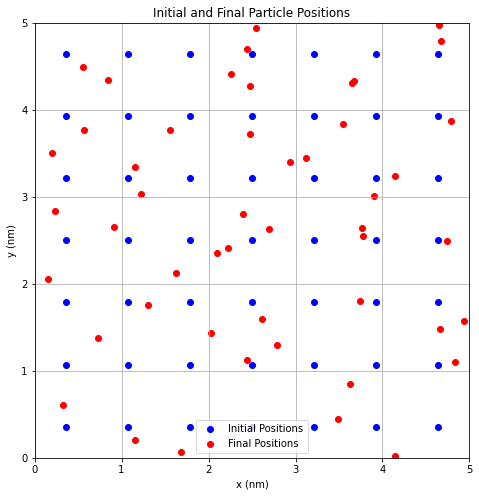

In [8]:
# Parameters for the simulation
box_size = 5.0  # Box size in nm
N_particles = 49  # Number of particles

C12 = 9.847044e-3  # Lennard-Jones constant for repulsion kg, nm, ns
C6 = 6.2647225  # Lennard-Jones constant for attraction kg, nm, ns
temperature = 293.15  # Temperature in K
step_shift = 0.01  # Random displacement step size in nm
steps = 2000  # Total Monte Carlo steps
record_interval = 20  # Save trajectory every 20 steps

# Initialize particle positions (regular grid)
particles = np.zeros((5, N_particles))  # Mass, x, y, vx, vy

# Create a regular grid within the box
grid_size = int(np.sqrt(N_particles))  # Number of particles per row/column
spacing = box_size / grid_size  # Spacing between particles

# Assign positions
x_coords = np.linspace(spacing / 2, box_size - spacing / 2, grid_size)
y_coords = np.linspace(spacing / 2, box_size - spacing / 2, grid_size)
x, y = np.meshgrid(x_coords, y_coords)

particles[1] = x.flatten()[:N_particles]  # x-coordinates
particles[2] = y.flatten()[:N_particles]  # y-coordinates

# Run the Monte Carlo simulation
energ_pot, traj = monte_carlo_simulation(particles, steps, step_shift, temperature, C12, C6, box_size, record_interval, verbose=True)




**Task 3: Potential energy analysis**

Next, the systems potential enrgy over the number of steps was plottet. Subsequently a histogram of the full system potential energies appearing during the equilibrated part of the MC trajectory was plottet.

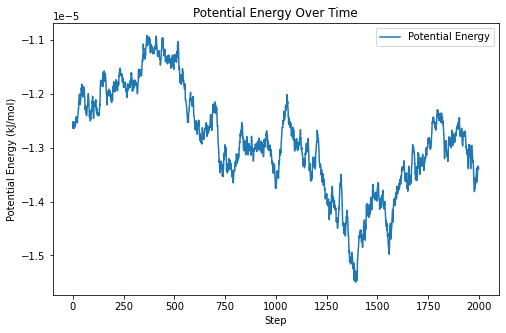

In [9]:
# Plot the system’s potential energy over the number of steps
plt.figure(figsize=(8, 5))
plt.plot(range(steps), energ_pot, label="Potential Energy")
plt.xlabel("Step")
plt.ylabel("Potential Energy (kJ/mol)")
plt.title("Potential Energy Over Time")
plt.legend()
plt.show()


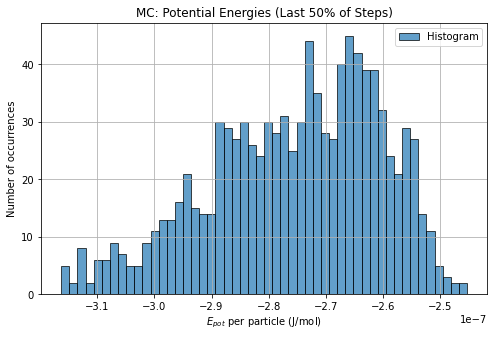

In [10]:

# Select the last 50% of the steps
last_half_start = len(energ_pot) // 2
last_half_energies = energ_pot[last_half_start:]

# Normalize potential energy per particle for the last half
last_half_energies_per_particle = last_half_energies / particles.shape[1]  # Divide by number of particles

# Plot histogram
plt.figure(figsize=(8, 5))
plt.title("MC: Potential Energies (Last 50% of Steps)")
plt.hist(last_half_energies_per_particle, bins=50, edgecolor='k', alpha=0.7, label="Histogram")
plt.xlabel("$E_{pot}$ per particle (J/mol)")
plt.ylabel("Number of occurrences")
plt.legend()
plt.grid()
plt.show()


Does it look like a Boltzmann distribution? haha maybe?

**Task IV: RDF and free energy comparison with MD**

The first class, "Box", contains all functions related to creating the simulation box, adding particles, and managing their interactions. Most of these functions were carried over from previous exercises. The function "fill_particles" was extended with an option to just fill particles to the left side of the box. This will later be used in accordance with the theory outlined in the above background section.

In [6]:

from math import nan

from numpy import float64, newaxis

class Box():
    """Box-class: defining a rectangular box-shape, in which Particles can roam. One corner is always (0,0)\n
    box         : 2-dimensional array of the two lengths of the x- and y-axis, corresponding to the boundaries of the box.\n
    particles   : a list of all particles in the box\n
    n_particles : the number of particles inside of the box
    """
    def __init__(self, box_size, n_Particles:int):
        """Initializing the Box-class\n
        box_size    : a 2-dimensional array of the two lengths of the x- and y-axis, corresponding to the boundaries of the box.\n
        n_Particles : an integer of the number of Particles in the box. Needed to initialize all arrays correctly
        """
        # constants
        self.c_6        = 6.2647225     # kg/mol  *  nm**8/ns**2
        self.c_12       = 9.847044e-3   # kg/mol  *  nm**14/ns**2
        self.kB         = 1.380e-23     # J/K
        self.avogadro   = 6.022e23      # 1/mol

        self.box_size       = box_size
        # Particles statistics are no longer stored in a separate class but in arrays, which allows for easier calculations
        self.particles_pos  = np.zeros((n_Particles,2))
        self.particles_vel  = np.zeros((n_Particles,2))
        self.particles_acc  = np.zeros((n_Particles,2))

        self.particles_r    = np.zeros(n_Particles)
        self.combined_radii = self.particles_r[:,np.newaxis] + self.particles_r[np.newaxis,:]
        self.particles_m    = np.zeros(n_Particles, dtype=float64)

        # We use distance matrices for true distances (distances_mat) in x and y coords,
        # distances with ghost particles for cross boundary calculations (distance_ghost) in x and y coords
        # and the norm of the ghost_distances as a single float
        self.distance_mat   = np.zeros((n_Particles,n_Particles,2))
        self.distance_ghost = np.zeros((n_Particles,n_Particles,2))
        self.distance_abs   = np.zeros((n_Particles,n_Particles))
        self.distance_abs_ghost   = np.zeros((n_Particles,n_Particles))
        # A vectorial force matrix to store the forces between each pair of particles in both directions
        self.force_mat      = np.zeros((n_Particles,n_Particles,2))
        # Storing the energy types currently in the system
        self.potEnergy_mat  = np.zeros((n_Particles,n_Particles,2))
        self.kinEnergy_mat  = np.zeros((n_Particles,n_Particles))

        self.temp = 0 # K

        self.n_particles = n_Particles

    def __repr__(self):
        """printing for debugging"""
        return str("This is a box of size %0.2f by %0.2f" % (self.box_size[0],self.box_size[1]) + ", with %0.2f" % (self.n_particles) + " particles")

    def random_positions(self, axis, n_particles = 0) -> None:
        """return random positions for a number of particles (only one axis)\n
        axis        : either 0 or 1.     0 = x-axis, 1 = y-axis\n
        n_particles : the number of particles for which positions should be given; default self.n_particles\n
        returns     : array of random positions
        """
        if n_particles == 0:
            n_particles = self.n_particles
        rnd = np.random.rand(n_particles)*(self.box_size[axis]-0.5)
        return rnd

    def fixedtemp_velocities(self, target_temp):
        """Calculate initial velocities, so that the initial kinetic energy corresponds to a target temperature"""
        kin_energy = self.kB * target_temp
        velocities = np.sqrt(2 * (kin_energy/self.n_particles) / (self.particles_m / self.avogadro))
        return velocities

    def fill_particles(self, radius, mass, vel, angle = [], x = [], y = [], align = 'random', grid = np.zeros(2), target_temp = 300) -> None:
        """fills the particles-array with particles\n
        radius      : The radius of particles; either as array of length n for individual radii or int/float for a general radius\n
        vel         : The absolute velocity; either as array of length n for individual velocities or int/float for a uniform initial velocity\n
        angle       : The initial angles of the particles as array of length n for individual angles; default is uniformly distributed\n
        x,y         : initial positions as array of length n; default random positions 0.5 away from border; Only used when align = 'defined'\n
        align       : Type of Particle placement: random = random positions; grid = grid-like arrangement(needs corresponding grid argument); defined = as given by x,y input\n
        grid        : 2x2 array that defines how many Particles should be in the grid on the x- and y- axis. Take care of correct number of particles!
        """
        # filling radius and mass, if given as a number for all particles
        if type(radius) == int or type(radius) == float:
            self.particles_r = np.ones(self.n_particles)*radius
        else:
            self.particles_r = radius
        self.combined_radii = self.particles_r[:,np.newaxis] + self.particles_r[np.newaxis,:]
        if type(mass) == int or type(mass) == float:
            self.particles_m = np.ones(self.n_particles)*mass
        else:
            self.particles_m = mass

        # randomize the angles if not given
        if len(angle) == 0:
            angle = np.random.uniform(0,2 * np.pi, self.n_particles)
        # fill velocities if given as a number for all particles
        if type(vel) == int or type(vel) == float:
            vel = np.ones(self.n_particles)*vel
        elif type(vel) == str:
            vel = self.fixedtemp_velocities(target_temp)

        # calculate the coressponding velocities
        self.particles_vel[:,0] = np.sin(angle) * vel
        self.particles_vel[:,1] = np.cos(angle) * vel

        # check which particle arrangement should be choosen
        if align == 'random':
            self.particles_pos[:,0] = self.random_positions(0,self.n_particles)
            self.particles_pos[:,1] = self.random_positions(1,self.n_particles)

        elif align == 'grid':
            if np.prod(grid) == self.n_particles:
                # This monster is mainly the meshgrid of coordinates, adjusted to be the correct shape.
                # Additionally the entire grid is moved by 0.1 in x and y direction to avoid Particles directly on the edge
                # It is not an error, even if vsCode thinks so
                max_rad = np.max(self.particles_r)+0.01
                self.particles_pos[:,] = np.column_stack(np.array(np.meshgrid(np.linspace(0,self.box_size[0]-max_rad,num=grid[0],endpoint=False),
                                                                              np.linspace(0,self.box_size[1]-max_rad,num=grid[1],endpoint=False),
                                                                              indexing='ij')).reshape(2,self.n_particles)) + max_rad
            else:
                print('ERROR: Grid size does not match number of particles!')
            # self.forces = np.ones((self.n_particles, self.n_particles, 2))-1
        elif align == 'left-grid':
            if np.prod(grid) == self.n_particles:
                # This monster is mainly the meshgrid of coordinates, adjusted to be the correct shape.
                # Additionally, the entire grid is moved by 0.1 in x and y direction to avoid Particles directly on the edge
                # It is not an error, even if vsCode thinks so
                max_rad = np.max(self.particles_r)+0.01
                self.particles_pos[:,] = np.column_stack(np.array(np.meshgrid(np.linspace(0,self.box_size[0]/2-max_rad,num=grid[0],endpoint=False),
                                                                              np.linspace(0,self.box_size[1]-max_rad,num=grid[1],endpoint=False),
                                                                              indexing='ij')).reshape(2,self.n_particles)) + max_rad
            else:
                print('ERROR: Grid size does not match number of particles!')
            # self.forces = np.ones((self.n_particles, self.n_particles, 2))-1
        elif align == 'defined':
            self.particles_pos[:,0] = x
            self.particles_pos[:,1] = y
        self.calculate_temp()
        #print(self.temp)

    def move(self, dt = 1., vel = []) -> None:
        """moving the particle in the direction, where the velocity-vector points.\n
        dt  : the time-step moving forward; default = 1\n
        vel : a velocity vector for moving in that direction during a time-step of one; default = self.vel
        """
        if len(vel) == 0:
            vel = self.particles_vel
        self.particles_pos += vel*dt

    def wrap_around(self) -> None:
        """For continuous borders, i.e. a particle that exits to the right is entering from the left and vice versa\n
        particles   : Particles, which should be wrapped; default self.particles\n
        returns     : array of particles with new positions
        """
        self.particles_pos = self.particles_pos % self.box_size

    def reflect(self) -> None:
        """Reflecting particles on the edges of the box, if the hull is touching\n
        """
        positive = self.particles_pos+self.particles_r[:,np.newaxis]
        negative = self.particles_pos-self.particles_r[:,np.newaxis]
        #print(positive, negative)
        self.particles_vel[np.asarray(np.logical_and(positive > self.box_size, self.particles_vel > 0)).nonzero()] *= -1
        self.particles_vel[np.asarray(np.logical_and(negative < 0, self.particles_vel < 0)).nonzero()] *= -1
        self.particles_pos = np.where(np.logical_and(positive > self.box_size, self.particles_vel > 0),
                                      self.particles_pos-2*np.abs(positive - self.box_size[np.newaxis,:]), self.particles_pos)
        self.particles_pos = np.where(np.logical_and(negative < 0, self.particles_vel < 0), self.particles_pos+2*np.abs(negative), self.particles_pos)

    def collide_all(self) -> None:
        """Collide all particles if they overlap."""
        self.calculate_distance_matrix()
        distance_abs_triangle = np.triu(self.distance_abs)
        collisions = np.where(np.where(distance_abs_triangle == 0, np.inf, distance_abs_triangle) < self.combined_radii)
        if collisions[0].size != 0:
            for i in range(collisions[0].size):
                # print(collisions[0][i],collisions[1][i],'collided with a distance of ', distance_abs_triangle[collisions[0][i],collisions[1][i]])

                # defining re-used variables
                vel = self.particles_vel[collisions[0][i]] - self.particles_vel[collisions[1][i]]  # particles[i].vx-particles[j].vx
                v_x = vel[0]
                v_y = vel[1]

                r_x = self.distance_mat[collisions[0][i],collisions[1][i],0]
                r_y = self.distance_mat[collisions[0][i],collisions[1][i],1]

                R = self.combined_radii[collisions[0][i],collisions[1][i]]
                # angle between x-axis and line between particles
                if r_x == 0:
                    phi = 0
                else:
                    phi = np.arctan(r_y/r_x)

                #calculating the time needed to travel back in two steps:
                sqrt = 2*np.sqrt((r_x*v_x+r_y*v_y)**2-(v_x**2+v_y**2)*(r_x**2+r_y**2-R**2))

                delta_t = -1*(-2*(r_x*v_x+r_y*v_y) + sqrt)/(2*(v_x**2+v_y**2))

                #solving the quadratic equation results in two solutions (one positive and one negative), we want the negative solution, for backwards time-travel
                if delta_t > 0:
                    delta_t = -1*(-2*(r_x*v_x+r_y*v_y) - sqrt)/(2*(v_x**2+v_y**2))

                # rewind time to just outside of the collision
                self.particles_pos[(collisions[0][i],collisions[1][i]),:] += vel*delta_t
                # only calculate once, used multiple times
                sin_phi = np.sin(phi)
                cos_phi = np.cos(phi)

                # Get the velocities of particles i and j as variables
                v1x, v1y = self.particles_vel[collisions[0][i],0], self.particles_vel[collisions[0][i],1]
                v2x, v2y = self.particles_vel[collisions[1][i],0], self.particles_vel[collisions[1][i],1]

                # Calculate the updated velocities using the provided formulas: https://hermann-baum.de/elastischer_stoss/
                # the tangental part stays the same, the normal part changes. This is done in transformed coordinates and then transformed directly back
                new_v1x = (v1x * sin_phi - v1y * cos_phi) * sin_phi + (v2x * cos_phi + v2y * sin_phi) * cos_phi
                new_v1y = (-v1x * sin_phi + v1y * cos_phi) * cos_phi + (v2x * cos_phi + v2y * sin_phi) * sin_phi
                new_v2x = (v2x * sin_phi - v2y * cos_phi) * sin_phi + (v1x * cos_phi + v1y * sin_phi) * cos_phi
                new_v2y = (-v2x * sin_phi + v2y * cos_phi) * cos_phi + (v1x * cos_phi + v1y * sin_phi) * sin_phi

                # Update the particles' velocities
                self.particles_vel[collisions[0][i],0], self.particles_vel[collisions[0][i],1] = new_v1x, new_v1y
                self.particles_vel[collisions[1][i],0], self.particles_vel[collisions[1][i],1] = new_v2x, new_v2y
                #print(particles[i],particles[j],'collided with a distance of ', distance)

                # finish this time_step, that was rewound previously and open the boundaries again with np.mod
                self.particles_pos[(collisions[0][i],collisions[1][i]),:] += vel*-1*delta_t


    def update_pos(self, dt) -> None:
        """Updates the position according to the velocity-verlet algorithm\n
        dt  : The time step used
        """
        self.particles_pos = self.particles_pos + self.particles_vel*dt + 1/2*(self.particles_acc*dt**2)
        # always wrap around...
        self.wrap_around()

    def update_vel_acc(self, dt, lammda) -> None:
        """Updates the velocities according to the velocity-verlet algorithm. Therefore the updated accelerations are needed.\n
        dt  : The time step used
        """
        new_acc = self.calculate_acc()
        self.particles_vel = (self.particles_vel + 0.5*(self.particles_acc + new_acc)*dt) * lammda
        self.particles_acc = new_acc

    def calculate_acc(self):
        """Updates the accelerations according to the velocity-verlet algorithm\n
        """
        return np.sum(self.force_mat,axis=0)/self.particles_m[:,np.newaxis]

    def calculate_temp(self):
        """Updates the temperature of the system. For this a recalculation of the kinetic energies is necessary"""
        self.calculate_kinEnergy_matrix()
        self.temp = np.sum(self.kinEnergy_mat)/self.kB/self.avogadro

    def calculate_lammda(self, tau, target_temp, dt):
        """Calculates the lambda of the berendsen thermostat. If the temperature is zero, it gives back zero."""
        self.calculate_temp()
        if self.temp != 0:
            return np.sqrt(1 + (dt/tau)*(target_temp/self.temp - 1))
        else:
            print(f'temp is zero!!')
            return 0


    def update_step(self, target_temp, dt, thermostat = 'no', tau = 2e-3) -> None:
        """The heart of the velocity-verlet algoritm.\n
        dt  : The time step used
        """
        self.update_pos(dt)
        # Before calculating the new velocities/accelerations, the forces must be calculated, for which we need the distance_matrix
        self.calculate_distance_matrix()
        self.calculate_force_matrix()
        # if a thermostat is used, take a different lambda into account
        if thermostat == 'berends':
            lammda = self.calculate_lammda(tau, target_temp, dt)
        elif thermostat == 'no':
            lammda = 1
        self.update_vel_acc(dt, lammda)

    def md_step(self, dt):
        self.move(dt=dt)
        self.reflect()
        self.collide_all()
        self.reflect()


    def calculate_distance_matrix(self) -> None:
        """Calculates a matrix, containing x and y distances of all particles to all other particles in both directions.\n
        It is by nature not symmetric, but rather the upper triangle is negated and flipped"""
        self.distance_mat = self.particles_pos[np.newaxis, :, :] - self.particles_pos[:, np.newaxis, :] # shape: (n,n,2)

        # the ghost matrix is calculated to account for interactions that go over the boundary of the box.
        # This is adjusted, if the x or y distances is greater than half the box size, which makes the distance across boundaries shorter
        self.distance_ghost = np.where(self.distance_mat[:, :] > (0.5 * self.box_size),
                                       self.distance_mat[:, :] - self.box_size, self.distance_mat[:, :]) # shape: (n,n,2)
        self.distance_ghost = np.where(self.distance_ghost[:, :] < -(0.5 * self.box_size),
                                       self.distance_ghost[:, :] + self.box_size, self.distance_ghost[:, :]) # shape: (n,n,2)
        # The norm is calculated as well as the absolute distance between each Particle pair. Symmetric by nature
        self.distance_abs = np.linalg.vector_norm(self.distance_mat, axis = 2) # shape: (n,n)
        self.distance_abs_ghost = np.linalg.vector_norm(self.distance_ghost, axis = 2) # shape: (n,n)
        #self.distance_abs = np.where(self.distance_abs == 0, np.inf, self.distance_abs)

    def calculate_force_matrix(self) -> None:
        """Calculate the forces acting from each Particle onto each particle as a directional vector stored in a matrix"""
        distance_abs_newaxis = self.distance_abs[:, :, np.newaxis] # shape: (n,n,1); used for better matrix multiplication with numpy
        # We have to check for any distances of zero between Particles, which would not allow for any force-calculation
        # We set those forces to zero
        self.force_mat = np.where(distance_abs_newaxis != 0, (12*self.c_12/distance_abs_newaxis**14-6*
                                                              self.c_6/distance_abs_newaxis**8)*self.distance_ghost, 0)

    def calculate_potEnergy_matrix(self) -> None:
        """Calculate the potential energy of the system"""
        # Again we need to account for any division by zero
        self.potEnergy_mat = np.where(self.distance_abs != 0, (self.c_12/(self.distance_abs**12)-
                                                               self.c_6/(self.distance_abs**6)), 0) # shape: (n,n)

    def calculate_kinEnergy_matrix(self) -> None:
        """Calculate the current kinetic energy in the system."""
        self.kinEnergy_mat = 0.5 * self.particles_m * np.square(np.linalg.norm(self.particles_vel, axis=1)) # shape: (n) #could be optimized maybe? square of squareroot of squares

    def steepest_descent(self, distance = 0.05, counter = 100, accuracy = 1.):
        """Does a steepest descent search for this box to find an energetically optimal position.\n
        distance    : How far the particles should move in one time-step, default: for now 0.05nm; might change in the future - lower gives better results\n
        counter     : How many re-calculations of the forces should maximally happen, default: 100
        accuracy    : How accurat the end-position has to be to stop the search, default: 1
        """
        # store the potential energy of the system at each step
        pot_energies = []
        # calculate forces and energy for the initial time-step
        self.calculate_distance_matrix()
        self.calculate_force_matrix()
        self.calculate_potEnergy_matrix()
        pot_energies.append(self.potEnergy_mat)
        pot_energy_old = np.sum(self.potEnergy_mat)/2

        #counting upwards, relict from previous iteration. Dont want to change that now
        i = 0
        # run the while-loop until the counter is reached
        while i < counter:
            # Calculate the normalized direction to move in for all Particles
            move_direction = np.sum(self.force_mat,axis=0)
            move_direction = np.divide(move_direction,np.linalg.norm(move_direction))
            # Move in that direction until the bottom is reached
            pathway = True
            while pathway:
                self.move(dt=distance, vel=move_direction)
                self.calculate_distance_matrix()
                self.calculate_potEnergy_matrix()

                pot_energy_new_mat = self.potEnergy_mat
                pot_energy_new = np.sum(pot_energy_new_mat)/2
                # Check wether next energy is lower than previous one
                if pot_energy_new < np.sum(pot_energies[-1])/2:
                    # save the new energies
                    pot_energies.append(pot_energy_new_mat)
                else:
                    # move backwards to the last place
                    self.move(dt=-distance, vel=move_direction)
                    # recalculate the forces
                    self.calculate_distance_matrix()
                    self.calculate_force_matrix()
                    # count upwards and recalculate the moving direction in the next while-loop-iteration
                    i += 1
                    pathway = False
            # Check wether a local minimum is reached either if the energies get smaller insignificantly
            # or the new energies never get lower (mostly due to a large step size, so the next valley is hit)
            if np.abs(pot_energy_old - np.sum(pot_energies[-1])/2) < accuracy or pot_energy_new == pot_energy_old:
                #print('Ending steepest descent; reached local minimum')
                i = counter + 1
            else:
                pot_energy_old = pot_energy_new
        # return list of all energies (e.g. for plotting)
        return pot_energies



The "Simulation class" encompasses all functions dealing with the execution of the simulation. Again, all functions have been already introduced in previous excercises.

In [7]:
class Simulation:
    """Simulation class for everything related to simulating the particles in a box\n
    box         : The box object which should be simulated
    steps       : The number of integration steps to perform
    dt          : The length of one time step
    data_traj   : The trajectories of all particles
    """
    def __init__(self, box:Box, steps, dt, target_temp = 300) -> None:
        """Initializing the Simulation\n
    box         : The box object which should be simulated
    steps       : The number of integration steps to perform
    dt          : The length of one time step
    """
        self.box:Box = box
        self.steps = steps
        self.dt = dt
        self.target_temp = target_temp
        self.set_traj()

    def set_traj(self) -> None:
        """Initialize the trajectory-saving"""
        self.data_traj  = np.zeros((self.box.n_particles, 3, 2, self.steps+1))
        self.pot_energy = np.zeros((self.box.n_particles, self.box.n_particles, self.steps+1))
        self.kin_energy = np.zeros((self.box.n_particles, self.steps+1))
        self.temps      = np.zeros((self.steps+1))

    def run(self, force_type = 'lennard-jones') -> None:
        self.set_traj()
        if force_type == 'lennard-jones':
            # Save the initial configuration
            self.data_traj[:,0,:,0], self.data_traj[:,1,:,0], self.data_traj[:,2,:,0] = self.box.particles_pos, self.box.particles_vel, self.box.particles_acc
            self.box.calculate_distance_matrix()
            self.box.calculate_potEnergy_matrix()
            self.box.calculate_kinEnergy_matrix()
            self.pot_energy[:,:,0] = self.box.potEnergy_mat
            self.kin_energy[:,0] = self.box.kinEnergy_mat
            self.temps[0] = self.box.temp
            # Iterate through each step
            for i in range(self.steps):
                # do velocity verlet and save pos, vel and acc
                self.box.update_step(self.target_temp, self.dt, thermostat='berends')
                self.data_traj[:,0,:,i+1], self.data_traj[:,1,:,i+1], self.data_traj[:,2,:,i+1] = self.box.particles_pos, self.box.particles_vel, self.box.particles_acc
                # calculate energies and save those as well
                self.box.calculate_potEnergy_matrix()
                self.box.calculate_kinEnergy_matrix()
                self.pot_energy[:,:,i+1] = self.box.potEnergy_mat
                self.kin_energy[:,i+1] = self.box.kinEnergy_mat
                self.temps[i+1] = self.box.temp
        elif force_type == 'hard-spheres':
            # Save the initial configuration
            self.data_traj[:,0,:,0], self.data_traj[:,1,:,0], self.data_traj[:,2,:,0] = self.box.particles_pos, self.box.particles_vel, self.box.particles_acc
            # self.box.calculate_distance_matrix()
            self.box.calculate_kinEnergy_matrix()
            self.kin_energy[:,0] = self.box.kinEnergy_mat
            self.temps[0] = self.box.temp
            # Iterate through each step
            for i in range(self.steps):
                # do MD and save pos, vel and acc
                self.box.md_step(self.dt)
                self.data_traj[:,0,:,i+1], self.data_traj[:,1,:,i+1], self.data_traj[:,2,:,i+1] = self.box.particles_pos, self.box.particles_vel, self.box.particles_acc
                # calculate energies and save those as well
                self.box.calculate_kinEnergy_matrix()
                self.kin_energy[:,i+1] = self.box.kinEnergy_mat
                self.temps[i+1] = self.box.temp





The final class, the "Analysis" class houses all functions dealing with the analysis of the simulation.All functions have been introduced in previous excercises.

In [8]:
class Analysis():
    def __init__(self, sim:Simulation) -> None:
        self.sim = sim

    def show_traj(self):
        """Shows a 2D-plot of all trajectories"""
        for data_traj_j in self.sim.data_traj:
            plt.plot(data_traj_j[0][0],data_traj_j[0][1],'-')
        plt.xlabel('position x')
        plt.ylabel('position y')

        plt.grid()
        plt.show()
    def setup(self):
        """setup the animation"""
        self.fig, self.ax = plt.subplots()

        self.ax.set_xlim((0, self.sim.box.box_size[0]))
        self.ax.set_ylim((0, self.sim.box.box_size[1]))

        plt.xlabel('position x')
        plt.ylabel('position y')

        # make the points in the plot the correct size according to the radius of the particles
        # use ax.transData.transform to convert radius size from particle to markerSize from pyplot
        desired_size_in_data_units = self.sim.box.particles_r[0]/6
        data_to_points = self.ax.transData.transform((desired_size_in_data_units, 0))-self.ax.transData.transform((0, 0))
        marker_size_in_points = data_to_points[0]


        self.dot, = self.ax.plot([], [], 'bo', ms=marker_size_in_points)

    def init_vid(self):
        """initialize the video"""
        self.dot.set_data([], [])
        return (self.dot,)
    # animation function. This is called sequentially

    def animate(self,i):
        """animate the video"""
        x = self.sim.data_traj[:,0,0,i]
        y = self.sim.data_traj[:,0,1,i]
        self.dot.set_data(x, y)
        return (self.dot,)

    def animation(self, save_pls = False):
        """create and save a video of the simulation"""
        self.setup()
        anim = animation.FuncAnimation(self.fig, self.animate, init_func=self.init_vid,
                                       frames=self.sim.steps, interval=2, blit=True)
        HTML(anim.to_html5_video())

        # uncomment if video should not be saved
        if save_pls:
            anim.save('animation.mp4', fps=30)

    def histogram_vel_axis(self, axis):
        """histogram of the x velocity"""
        a = []
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                a.append((self.sim.data_traj)[j, 1, axis, i])

        plt.hist(a,bins=50)
        plt.xlabel('velocity x')
        plt.ylabel('occupancy')
        plt.show()

    def histogram_pos_axis(self, axis):
        list_for_histogramm = []
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                list_for_histogramm.append((self.sim.data_traj)[j, 0, axis, i])

        plt.hist(list_for_histogramm,range=(0,self.sim.box.box_size[axis]),bins=10)
        plt.xlabel('position x')
        plt.ylabel('occupancy')
        plt.show()

    def histogram_pos_2d(self):
        """2d plot of the position distribution"""
        a = []
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                a.append((self.sim.data_traj)[j, 0, 0, i])
        b = []
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                b.append((self.sim.data_traj)[j, 0, 1, i])


        plt.hist2d(a, b, range=[[0,self.sim.box.box_size[0]],[0,self.sim.box.box_size[1]]], bins=10)
        plt.xlabel('position x')
        plt.ylabel('position y')
        plt.colorbar().set_label('occupancy')
        plt.show()

    def histogram_vel_abs(self):
        #0 = 0
        all_velocities = np.array([])
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                velocity = np.sqrt((self.sim.data_traj[j, 1, 0, i])**2 + (self.sim.data_traj[j, 1, 1, i])**2)
                all_velocities = np.append(all_velocities,velocity)

        plt.hist(all_velocities,bins=100)
        plt.xlabel('velocity |v|')
        plt.ylabel('occupancy')
        plt.show()

    def histogram_vel_last2first(self, percent, axis = 0):
        # comparison of different iteration parts

        # first 10%
        a = []
        for i in range(int(percent * self.sim.steps)):
            for j in range(self.sim.box.n_particles):
                a.append(self.sim.data_traj[j, 1, axis, i])

        # last 10%
        b = []
        for i in range(int((1-percent) * self.sim.steps),self.sim.steps):
            for j in range(self.sim.box.n_particles):
                b.append(self.sim.data_traj[j, 1, axis, i])

        plt.hist(a,bins=10, label = 'first 10% iterations')
        plt.hist(b,bins=10, label = 'last 10% iterations', alpha=0.5)
        plt.xlabel('velocity x')
        plt.ylabel('occupancy')
        plt.legend()
        plt.show()

    def plot_energies(self, kin = True, pot = True, com = True):
        fig, ax = plt.subplots(figsize=(16, 9))

        if pot:
            ax.plot(np.linspace(0,self.sim.steps,self.sim.steps+1),
                    np.sum(np.sum(self.sim.pot_energy,axis=0),axis=0)/2,label='pot')
        if kin:
            ax.plot(np.linspace(0,self.sim.steps,self.sim.steps+1),
                    np.sum(self.sim.kin_energy,axis=0),label='kin')
        if com:
            ax.plot(np.linspace(0,self.sim.steps,self.sim.steps+1),np.sum(self.sim.kin_energy,axis=0)
                    +np.sum(np.sum(self.sim.pot_energy,axis=0),axis=0)/2,label='com')

        ax.set_xlabel('time [s]')
        ax.set_ylabel('energy [g/mol m/s]')

        plt.legend()

    def exercise_four(self):
        """Calculates the two values from the exercise sheet 4"""
        rel_mom = np.sum(np.linalg.norm(self.sim.data_traj[:,2,:,:], axis = 1)
                         *self.sim.box.particles_m[:,np.newaxis], axis = 0)**2
        uno = np.var(rel_mom)/(np.mean(rel_mom)**2)
        dos = np.var(self.sim.temps)/(np.mean(self.sim.temps)**2)
        return uno, dos